### Sentiment anlysis on gaurdian articles using DistilBERT

It is recommended to run this notebook in Colab

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

You will need the following package: (uncomment and run to install)

In [ ]:
#!pip install -q transformers

You will need the following packages if you are not on Colab: (uncomment and run to install)

In [ ]:
#!pip3 install torch
#!pip3 install protobuf==3.20.0
#!pip install pip install tqdm

In [2]:
with open('../datasets/guardian.json', 'r') as f:
    guardian = json.load(f)

In [ ]:
# from transformers import pipeline
# sentiment_pipeline = pipeline("sentiment-analysis")
headline = guardian['Afghanistan'][0]['fields']['headline']
sentiment = sentiment_pipeline(headline)
print(f'Headline: {headline}')
print(f'Sentiment: {sentiment}')

In [ ]:
countries = guardian.keys()
sentiment = {key: [] for key in countries}
for country in countries:
    for i, article in enumerate(guardian[country]):
        sentiment[country].append(sentiment_pipeline(article['fields']['headline']) + [str(pd.to_datetime(article['webPublicationDate']).date())])

In [ ]:
with open('sentiment_analysis.json', 'w') as outfile:
    json.dump(sentiment, outfile)

In [ ]:
dfs = []
for country in sentiment.keys():
    df_country = pd.DataFrame(sentiment[country])
    positive = df_country[0].apply(lambda x: x['label'] == 'POSITIVE')
    confidence = df_country[0].apply(lambda x: x['score'])
    date = pd.to_datetime(df_country[1])
    df_country = pd.concat([positive, confidence, date, pd.Series([country]*len(df_country))], axis=1)
    df_country.columns = ['positive', 'confidence', 'date', 'country']
    dfs.append(df_country)
    
df_sentiment = pd.concat(dfs)

In [6]:
start_date = pd.to_datetime("2008-01-01")
end_date = pd.to_datetime("2022-06-01")
n_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
bins = [start_date + pd.DateOffset(months=i) for i in range(n_months + 1)]

result_df = pd.DataFrame(bins, columns=['date']).set_index('date')


for country in guardian.keys():
    dates = []
    for article in guardian[country]:
        dates.append(article['webPublicationDate'])
    dates = pd.to_datetime(pd.Series(dates)).apply(lambda t: t.replace(tzinfo=None))

    df = pd.cut(dates, bins).value_counts()
    value_counts = []
    l = []
    for i in range(len(df)):
        l.append([df.index[i].left, df[i]])
    result_df = result_df.merge(pd.DataFrame(l, columns=['date', country]).set_index('date'), left_index=True, right_index=True)

In [822]:
pd.DataFrame(result_df.sum().sort_values())

Djibouti                      465
Eswatini                      511
Lesotho                       553
Mauritania                    660
Burundi                       908
Burkina Faso                 1157
Namibia                      1403
Madagascar                   1423
Angola                       1714
Mozambique                   1823
Zambia                       1932
Niger                        1942
Malawi                       1981
Guatemala                    2005
Honduras                     2363
Mali                         3016
Chad                         3126
Tanzania                     3241
Haiti                        3252
Ethiopia                     4717
Somalia                      4981
Uganda                       5616
Congo                        5857
Zimbabwe                     6075
Sudan                        6115
Yemen                        6178
El Salvador                  6579
Kenya                        9446
Nigeria                     10011
Pakistan      

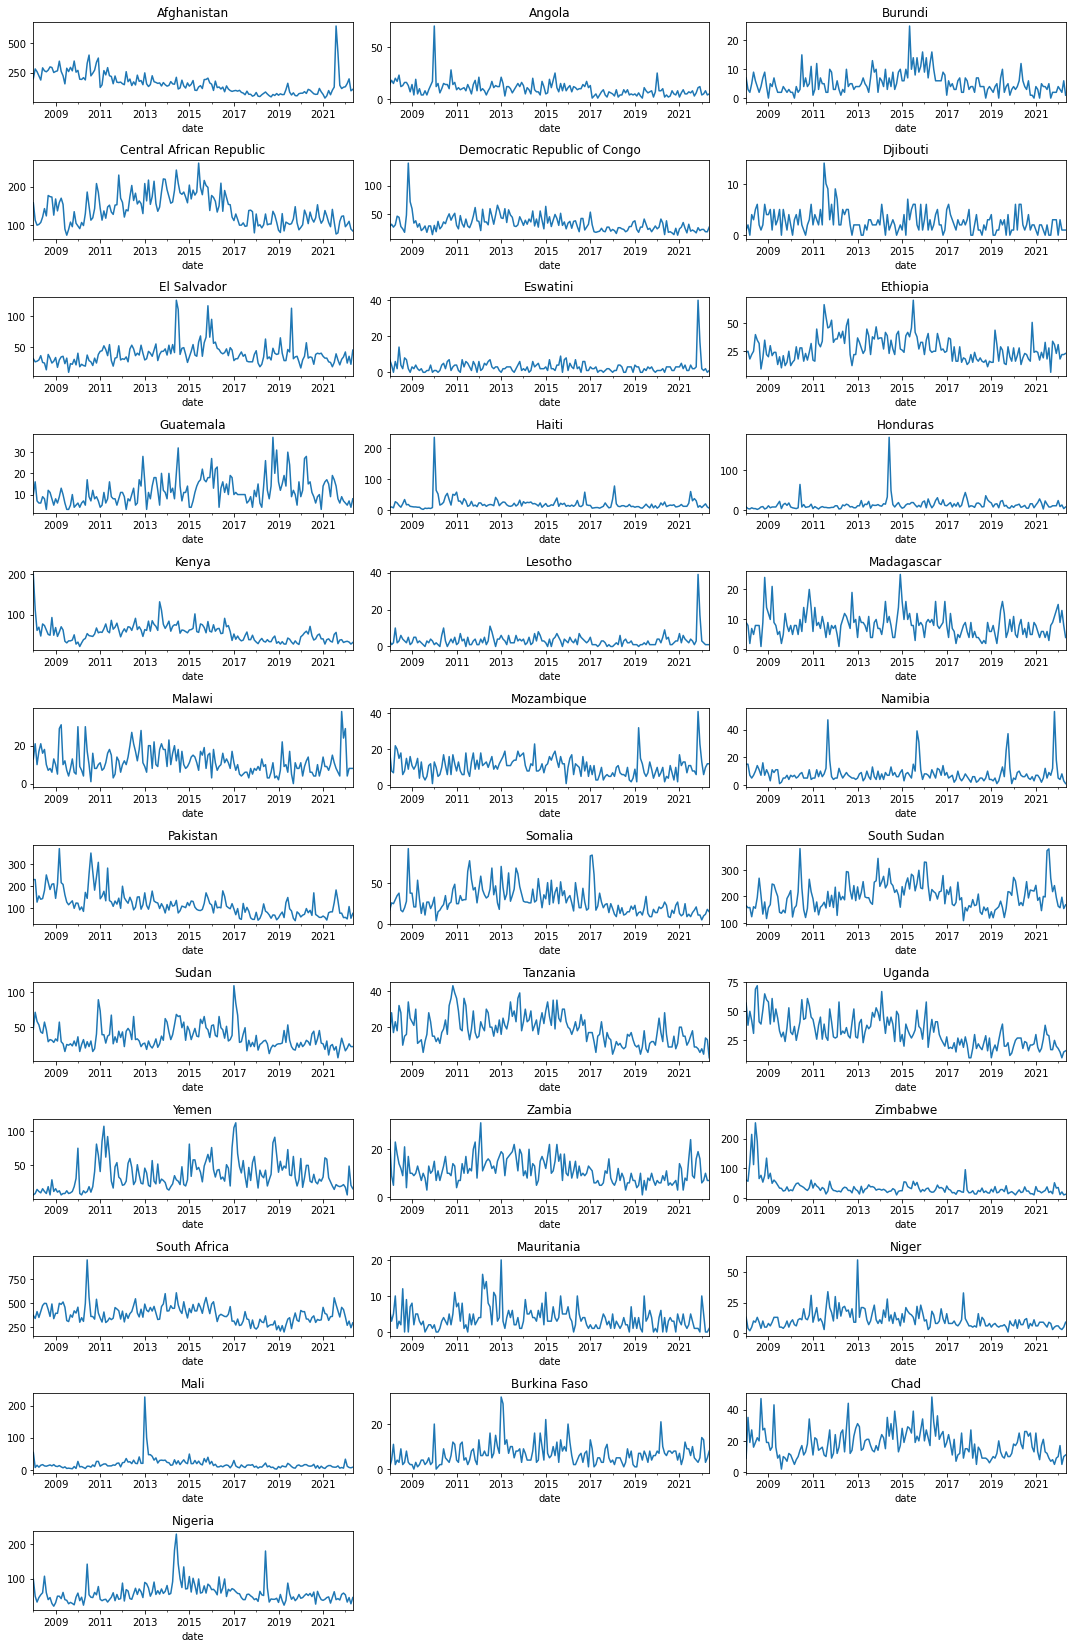

In [745]:
cols = result_df.columns
fig, axs = plt.subplots(nrows=len(cols)//3 + 1, ncols=3, figsize=(15, 23))

for i, col in enumerate(result_df.columns):
    ax = axs.flatten()[i]
    result_df[col].plot(ax=ax)
    ax.set_title(col)
    if col == 'Congo':
        ax.set_title('Democratic Republic of Congo')
    
axs.flatten()[-2].axis('off')
axs.flatten()[-1].axis('off')
plt.tight_layout()

plt.savefig("articles_published_monthly.pdf", format="pdf")